# College Selection using DEA → ANP (Synthetic Example)

This notebook shows a complete, **runnable** example of how a 12th-pass student
can use a **two-stage analytics pipeline** to choose an engineering college:

1. **Stage 1 – DEA (Data Envelopment Analysis)**  
   - Compare **30 synthetic colleges** on measurable inputs & outputs.  
   - Use **input-oriented CCR DEA** to compute an efficiency score for each college.  
   - Shortlist the **top 7** colleges.

2. **Stage 2 – ANP (Analytic Network Process)**  
   - On the shortlisted 7 colleges, consider **personal and qualitative criteria** such as:  
     distance from home, hostel availability, branch availability, financial factors,
     campus life and reputation.  
   - Use a simplified **ANP-style supermatrix** to compute final priorities and visualize
     the best choices.

In [2]:
# Dynamic entry for Student's rank

while True:
    try:
        user_input = input("Enter your examination rank (positive integer): ").strip()
        student_rank = int(user_input)
        if student_rank <= 0:
            raise ValueError("Rank must be a positive integer.")
        break
    except ValueError as e:
        print(f"Invalid input: {e}. Please try again.")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import linprog

In [4]:
# Plot settings

plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 6
plt.rcParams['figure.edgecolor'] = 'black'
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.figsize'] = (8, 4)
plt.rcParams['figure.dpi'] = 120

In [5]:
np.random.seed(123)  # Reproducibility

### Utility Functions definition

In [6]:
def principal_eigenvector(matrix):
    """
    Compute the principal eigenvector of a positive matrix
    and normalize it to sum to 1.
    """
    vals, vecs = np.linalg.eig(matrix)
    idx = np.argmax(vals.real)
    v = np.abs(vecs[:, idx].real)
    return v / v.sum()


In [7]:
def scores_to_pcm(scores, reverse=False):
    """
    Build a pairwise comparison matrix from a vector of scores.
    - If reverse is False: higher score = more preferred.
    - If reverse is True: lower score = more preferred.
    """
    n = len(scores)
    pcm = np.ones((n, n))
    for i in range(n):
        for j in range(n):
            if reverse:
                # lower is better
                val = scores[j] / (scores[i] + 1e-9)
            else:
                val = scores[i] / (scores[j] + 1e-9)
            pcm[i, j] = val
    return pcm


In [8]:
def calculate_rank_fit_score(student_rank, cutoff_rank):
    """
    Calculate rank fit score using improved continuous scoring method.
    
    Args:
        student_rank: Student's examination rank
        cutoff_rank: College's cutoff rank
    
    Returns:
        Rank fit score:
        - 1.0 = Easy admission (student rank in top 50% below cutoff)
        - 0.5 = Borderline (exactly at cutoff)
        - >0 = Even if above cutoff (exponential decay)
    
    Improvements over previous binary approach:
    - Continuous scoring instead of binary 0/1
    - Percentile-based for colleges within reach
    - Exponential decay for colleges above cutoff (still gives some score)
    """
    if student_rank <= cutoff_rank:
        # Student is within cutoff - calculate percentile position
        percentile = student_rank / cutoff_rank
        if percentile <= 0.5:
            # Top 50% below cutoff = easy admission
            rank_fit = 1.0
        else:
            # Between 50-100% = linear decay from 1.0 to 0.5
            rank_fit = (1 - percentile) * 2
    else:
        # Student rank is above cutoff - exponential decay
        excess = student_rank - cutoff_rank
        rank_fit = 0.5 * np.exp(-excess / 10000)
    
    return rank_fit


In [9]:
def calculate_consistency_ratio(pairwise_matrix):
    """
    Calculate the Consistency Ratio (CR) for a pairwise comparison matrix.
    
    Args:
        pairwise_matrix: Square matrix of pairwise comparisons
    
    Returns:
        cr: Consistency Ratio
        is_consistent: Boolean indicating if CR < 0.10 (acceptable)
    
    Formula:
        CR = CI / RI
        where CI = (λ_max - n) / (n - 1)
        λ_max = principal eigenvalue
        RI = Random Index from Saaty's table
    
    Acceptable threshold: CR < 0.10
    """
    # Random Index values from Saaty's tables
    random_index = {
        1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
        6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49
    }
    
    n = pairwise_matrix.shape[0]
    
    if n <= 2:
        return 0.0, True  # Always consistent for n <= 2
    
    # Calculate principal eigenvalue
    eigenvalues = np.linalg.eigvals(pairwise_matrix)
    lambda_max = np.max(eigenvalues.real)
    
    # Calculate Consistency Index
    ci = (lambda_max - n) / (n - 1)
    
    # Get Random Index for matrix size
    ri = random_index.get(n, 1.49)  # Use 1.49 for n > 10
    
    # Calculate Consistency Ratio
    cr = ci / ri if ri > 0 else 0.0
    
    is_consistent = cr < 0.10
    
    return cr, is_consistent


## Stage 1 – DEA (Data Envelopment Analysis)

**IMPROVEMENT #1: Cutoff Rank as Pre-Filter**
- Cutoff rank is now used as a constraint to filter colleges
- Only colleges within student's reach are analyzed
- Prevents illogical efficiency assessments

In [10]:
def principal_eigenvector(matrix):
    """
    Compute the principal eigenvector of a positive matrix
    and normalize it to sum to 1.
    """
    vals, vecs = np.linalg.eig(matrix)
    idx = np.argmax(vals.real)
    v = np.abs(vecs[:, idx].real)
    return v / v.sum()

In [11]:
def scores_to_pcm(scores, reverse=False):
    """
    Build a pairwise comparison matrix from a vector of scores.
    - If reverse is False: higher score = more preferred.
    - If reverse is True: lower score = more preferred.
    """
    n = len(scores)
    pcm = np.ones((n, n))
    for i in range(n):
        for j in range(n):
            if reverse:
                # lower is better
                val = scores[j] / scores[i]
            else:
                val = scores[i] / scores[j]
            pcm[i, j] = val
    return pcm

## Stage 1 – DEA: Screening 30 Engineering Colleges

**Goal:** Rank many colleges on *efficiency* using objective, measurable criteria.

Each **college** is a **DMU (Decision Making Unit)**.  
We define **inputs** (resources the college uses) and **outputs** (results it produces).

### Inputs (resources – want to minimize for given outputs)
1. `Faculty_FTE` – Number of full-time equivalent faculty members.
 
2. `PhD_Faculty_Count` – Number of PhD-qualified faculty members.  

3. `Total_Beds_in_hostel` – Total hostel beds (proxy for residential infrastructure).  

4. `Infrastructure_Score` – 0–100 index for labs, library, workshops, etc.  

5. `Operating_Expenditure_Lakh` – Annual operating expenditure (in INR lakhs).

### Outputs (performance – want to maximize)
1. `Placement_Rate` – % of eligible students placed (0–100).  

2. `Average_Package_LPA` – Average package of placed students (in LPA).  

3. `Research_Publications` – Number of peer-reviewed publications last year.  

4. `Student_Satisfaction` – 0–100 student feedback index.  

5. `Graduation_Rate` – % of students graduating on time.


In [12]:
# Generate synthetic DEA data

num_colleges = 30
colleges = [f"C{i+1}" for i in range(num_colleges)]

# We create size categories: large, medium, small
sizes = np.random.choice(["large", "medium", "small"], size=num_colleges, p=[0.3, 0.4, 0.3])

Faculty_FTE = []
PhD_Faculty_Count = []
Total_Beds_in_hostel = []
Infrastructure_Score = []
Operating_Expenditure_Lakh = []

Placement_Rate = []
Average_Package_LPA = []
Research_Publications = []
Student_Satisfaction = []
Graduation_Rate = []

for sz in sizes:
    if sz == "large":
        fac = np.random.randint(100, 180)        # more faculty
        phd = np.random.randint(int(fac*0.2), int(fac*0.5))
        beds = np.random.randint(800, 2000)
        infra = np.random.randint(75, 90)
        op_cost = np.random.randint(1000, 2000)  # lakh
        
        placement = np.random.normal(85, 5)
        avg_pkg = np.random.normal(7.0, 1.0)
        pubs = int(np.random.normal(40, 15))
        sat = np.random.normal(82, 5)
        grad = np.random.normal(92, 3)
    elif sz == "medium":
        fac = np.random.randint(60, 110)
        phd = np.random.randint(int(fac*0.15), int(fac*0.4))
        beds = np.random.randint(400, 1200)
        infra = np.random.randint(65, 82)
        op_cost = np.random.randint(600, 1200)
        
        placement = np.random.normal(78, 6)
        avg_pkg = np.random.normal(5.5, 0.8)
        pubs = int(np.random.normal(20, 8))
        sat = np.random.normal(78, 6)
        grad = np.random.normal(88, 4)
    else:  # small
        fac = np.random.randint(30, 70)
        phd = np.random.randint(int(fac*0.1), int(fac*0.3))
        beds = np.random.randint(0, 800)
        infra = np.random.randint(55, 72)
        op_cost = np.random.randint(300, 800)
        
        placement = np.random.normal(70, 7)
        avg_pkg = np.random.normal(4.0, 0.7)
        pubs = int(np.random.normal(8, 4))
        sat = np.random.normal(73, 7)
        grad = np.random.normal(82, 5)

    # Clip to reasonable ranges
    placement = float(np.clip(placement, 40, 99))
    avg_pkg = float(np.clip(avg_pkg, 2.0, 12.0))
    pubs = max(pubs, 0)
    sat = float(np.clip(sat, 40, 95))
    grad = float(np.clip(grad, 60, 99))

    Faculty_FTE.append(fac)
    PhD_Faculty_Count.append(phd)
    Total_Beds_in_hostel.append(beds)
    Infrastructure_Score.append(infra)
    Operating_Expenditure_Lakh.append(op_cost)

    Placement_Rate.append(placement)
    Average_Package_LPA.append(avg_pkg)
    Research_Publications.append(pubs)
    Student_Satisfaction.append(sat)
    Graduation_Rate.append(grad)
    
    College_Cutoff_Rank = np.random.randint(500, 50000, size=num_colleges)

dea_df = pd.DataFrame({
    "College": colleges,
    "Size_Category": sizes,
    "Faculty_FTE": Faculty_FTE,
    "PhD_Faculty_Count": PhD_Faculty_Count,
    "Total_Beds_in_hostel": Total_Beds_in_hostel,
    "Infrastructure_Score": Infrastructure_Score,
    "Operating_Expenditure_Lakh": Operating_Expenditure_Lakh,
    "Placement_Rate": Placement_Rate,
    "Average_Package_LPA": Average_Package_LPA,
    "Research_Publications": Research_Publications,
    "Student_Satisfaction": Student_Satisfaction,
    "Graduation_Rate": Graduation_Rate,
    "College_Cutoff_Rank": College_Cutoff_Rank
})

dea_df.head()


,College,Size_Category,Faculty_FTE,PhD_Faculty_Count,Total_Beds_in_hostel,Infrastructure_Score,Operating_Expenditure_Lakh,Placement_Rate,Average_Package_LPA,Research_Publications,Student_Satisfaction,Graduation_Rate,College_Cutoff_Rank
0,C1,medium,102,20,976,76,1018,76.038323,5.253433,26,84.424689,75.777690,8494
1,C2,large,103,31,1555,83,1222,90.029660,6.227291,51,83.571360,88.021204,48686
2,C3,large,151,37,1798,83,1966,91.276187,6.311131,64,86.036541,91.055726,23556
3,C4,medium,84,26,615,70,1162,71.484586,5.684542,24,81.403473,79.675958,45933
4,C5,small,39,5,673,60,424,75.686389,4.349818,9,69.052532,77.013393,48017


### DEA model: Input-Oriented CCR

In [13]:
def dea_input_oriented_ccr(inputs, outputs):
    """
    Compute input-oriented CCR DEA efficiency scores for each DMU.
    inputs:  (n_dmu, n_inputs)
    outputs: (n_dmu, n_outputs)
    Returns: scores (theta) of length n_dmu
    """
    num_dmu = inputs.shape[0]
    num_inputs = inputs.shape[1]
    num_outputs = outputs.shape[1]
    
    scores = np.zeros(num_dmu)
    
    for d in range(num_dmu):
        x0 = inputs[d, :]
        y0 = outputs[d, :]
        
        # Variables: [theta, lambda_1, ..., lambda_n]
        c = np.zeros(1 + num_dmu)
        c[0] = 1.0  # minimize theta
        
        A_ub = []
        b_ub = []
        
        # Input constraints: sum_j lambda_j * x_ij - theta * x_i0 <= 0
        for i_in in range(num_inputs):
            row = np.zeros(1 + num_dmu)
            row[0] = -x0[i_in]
            row[1:] = inputs[:, i_in]
            A_ub.append(row)
            b_ub.append(0.0)
        
        # Output constraints: -sum_j lambda_j * y_rj <= -y0_r (i.e., sum_j lambda_j * y_rj >= y0_r)
        for r_out in range(num_outputs):
            row = np.zeros(1 + num_dmu)
            row[1:] = -outputs[:, r_out]
            A_ub.append(row)
            b_ub.append(-y0[r_out])
        
        A_ub = np.array(A_ub)
        b_ub = np.array(b_ub)
        
        # Bounds: 0 <= theta <= 1, lambda_j >= 0
        bounds = [(0, 1)] + [(0, None)] * num_dmu
        
        res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds, method="highs")
        if res.success:
            scores[d] = res.x[0]
        else:
            scores[d] = np.nan
    
    return scores

In [14]:
# IMPROVEMENT #1: Filter colleges by cutoff rank BEFORE DEA
# Only analyze colleges where student_rank <= cutoff_rank
print(f"\nFiltering colleges where student rank ({student_rank}) is within cutoff...")
reachable_colleges = dea_df[dea_df["College_Cutoff_Rank"] >= student_rank].copy()
print(f"Colleges within reach: {len(reachable_colleges)} out of {len(dea_df)}")

# Prepare input and output matrices (WITHOUT cutoff rank)
input_cols = ["Faculty_FTE", "PhD_Faculty_Count", "Total_Beds_in_hostel",
              "Infrastructure_Score", "Operating_Expenditure_Lakh"]
output_cols = ["Placement_Rate", "Average_Package_LPA", "Research_Publications",
               "Student_Satisfaction", "Graduation_Rate"]



Filtering colleges where student rank (4312) is within cutoff...
Colleges within reach: 26 out of 30


In [15]:
# Run DEA on reachable colleges only
inputs = reachable_colleges[input_cols].values.astype(float)
outputs = reachable_colleges[output_cols].values.astype(float)

dea_scores = dea_input_oriented_ccr(inputs, outputs)
reachable_colleges["DEA_Efficiency_Theta"] = dea_scores


In [16]:
# Sort by efficiency and display top colleges
dea_df_sorted = reachable_colleges.sort_values("DEA_Efficiency_Theta", ascending=False)
print(f"\nTop 10 efficient colleges (from {len(reachable_colleges)} reachable):")
dea_df_sorted.head(10)



Top 10 efficient colleges (from 26 reachable):


,College,Size_Category,Faculty_FTE,PhD_Faculty_Count,Total_Beds_in_hostel,Infrastructure_Score,Operating_Expenditure_Lakh,Placement_Rate,Average_Package_LPA,Research_Publications,Student_Satisfaction,Graduation_Rate,College_Cutoff_Rank,DEA_Efficiency_Theta
10,C11,medium,107,36,579,74,1184,74.693352,6.336308,10,68.382696,85.273985,41237,1.0
1,C2,large,103,31,1555,83,1222,90.029660,6.227291,51,83.571360,88.021204,48686,1.0
11,C12,small,45,8,557,59,592,79.299418,3.508161,4,75.803812,90.105057,40682,1.0
17,C18,large,116,50,1863,80,1703,90.457087,7.466374,44,86.144265,91.870276,14084,1.0
27,C28,large,109,45,1745,89,1517,87.677952,7.377828,52,87.849691,95.916830,27598,1.0
6,C7,small,49,11,39,69,329,65.852738,3.338994,13,65.086250,90.281276,12332,1.0
8,C9,medium,96,34,489,70,713,93.814112,4.405439,5,74.676704,92.476017,16235,1.0
16,C17,large,139,34,1270,88,1077,88.506237,7.685075,15,78.167751,94.055749,14688,1.0
28,C29,large,157,47,1754,82,1622,85.248786,7.230669,52,83.330264,92.610901,24047,1.0
24,C25,small,66,16,592,70,317,64.637383,4.109301,2,83.567745,89.320035,38227,1.0


### DEA plot and shortlist

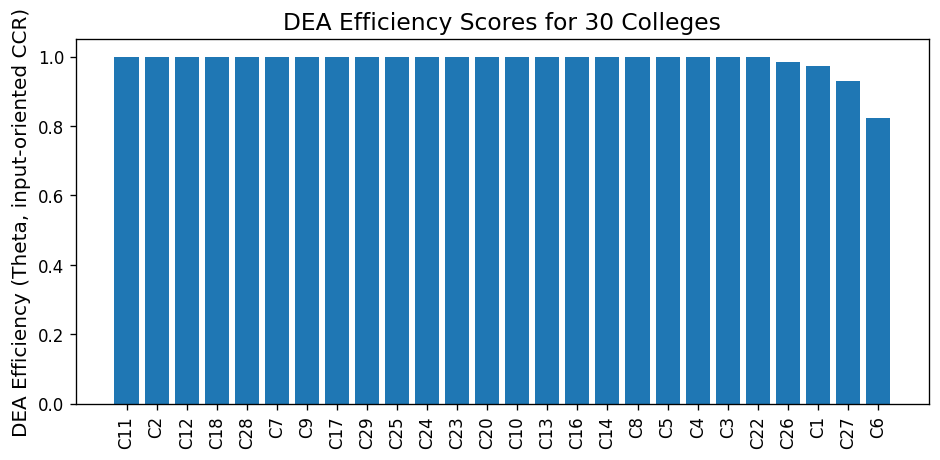

,College,Size_Category,Faculty_FTE,PhD_Faculty_Count,Total_Beds_in_hostel,Infrastructure_Score,Operating_Expenditure_Lakh,Placement_Rate,Average_Package_LPA,Research_Publications,Student_Satisfaction,Graduation_Rate,College_Cutoff_Rank,DEA_Efficiency_Theta
0,C11,medium,107,36,579,74,1184,74.693352,6.336308,10,68.382696,85.273985,41237,1.0
1,C2,large,103,31,1555,83,1222,90.029660,6.227291,51,83.571360,88.021204,48686,1.0
2,C12,small,45,8,557,59,592,79.299418,3.508161,4,75.803812,90.105057,40682,1.0
3,C18,large,116,50,1863,80,1703,90.457087,7.466374,44,86.144265,91.870276,14084,1.0
4,C28,large,109,45,1745,89,1517,87.677952,7.377828,52,87.849691,95.916830,27598,1.0
5,C7,small,49,11,39,69,329,65.852738,3.338994,13,65.086250,90.281276,12332,1.0
6,C9,medium,96,34,489,70,713,93.814112,4.405439,5,74.676704,92.476017,16235,1.0


In [17]:
# Visualize DEA efficiency scores
plt.figure()
plt.bar(dea_df_sorted["College"], dea_df_sorted["DEA_Efficiency_Theta"])
plt.xticks(rotation=90)
plt.ylabel("DEA Efficiency (Theta, input-oriented CCR)")
plt.title("DEA Efficiency Scores for 30 Colleges")
plt.tight_layout()
plt.show()

# Shortlist top 7 colleges
shortlist_size = 7
shortlisted = dea_df_sorted.head(shortlist_size).copy()
shortlisted.reset_index(drop=True, inplace=True)
shortlisted

<center>
    The table above shows the top 7 colleges after DEA.
</center>

## Stage 2 – ANP: Choosing among the 7 Shortlisted Colleges

Now we take the shortlisted colleges and consider **personal and qualitative criteria**.

### ANP Criteria and Clusters

We group criteria into **5 clusters**:

1. **Logistics (L)**  
   - `Distance_from_Home_km` (lower better)  
   
   - `Travel_Time_min` (lower better)  
   
   - `Hostel_Availability` (higher better, coded 0, 0.5, 1)

2. **Academic Fit (A)**  
   - `Branch_Offered` (1 if your branch is available; here we assume all 1 for demo)  
   
   - `Faculty_Student_Ratio` (higher better)  
   
   - `Curriculum_Relevance` (0–100; higher better)

3. **Financial (F)**  
   - `Total_Fee_per_year` (lower better)  
   
   - `Scholarship_Availability` (0–100; higher better)  
   
   - `Fee_Flexibility` (0 or 1; higher better)

4. **Campus Life & Safety (C)**  
   - `Campus_Safety_Index` (0–100; higher better)  
   
   - `Extracurriculars` (0–100; higher better)  
   
   - `Locality_Health_Facilities` (0–100; higher better)

5. **Reputation & Outcomes (R)**  
   - `Alumni_Network_Strength` (0–100; higher better)  
   
   - `Industry_Ties` (0–100; higher better)  
   
   - `Special_Accreditations` (0–100; higher better)

In [18]:
shortlisted_cols = shortlisted["College"].tolist()
n_alt = len(shortlisted_cols)

# Synthetic ANP data for shortlisted colleges

# Distance: some close, some far (km)
Distance_from_Home_km = np.random.randint(5, 600, size=n_alt)

# Travel time (minutes): roughly distance / speed + noise (assume 40-60 km/h)
Travel_Time_min = (Distance_from_Home_km / np.random.uniform(40, 60, size=n_alt)) * 60
Travel_Time_min = Travel_Time_min.astype(int)

# Hostel availability based on distance and size: if far, more likely good hostel
Hostel_Availability = []
for i, d in enumerate(Distance_from_Home_km):
    if d <= 30:
        # Close; hostel might be limited or optional
        Hostel_Availability.append(np.random.choice([0, 0.5, 1], p=[0.3, 0.5, 0.2]))
    elif d <= 200:
        Hostel_Availability.append(np.random.choice([0.5, 1], p=[0.4, 0.6]))
    else:
        Hostel_Availability.append(1.0)

Hostel_Availability = np.array(Hostel_Availability)

# IMPROVEMENT #2: Use improved rank fit scoring function
# Calculate rank fit score using percentile-based continuous scoring
Rank_Fit_Score = np.array([
    calculate_rank_fit_score(student_rank, cutoff)
    for cutoff in shortlisted["College_Cutoff_Rank"].values
])

print("\nRank Fit Scores (Improved):")
for college, cutoff, score in zip(shortlisted_cols, shortlisted["College_Cutoff_Rank"].values, Rank_Fit_Score):
    print(f"  {college}: Cutoff={cutoff}, Student={student_rank}, Score={score:.4f}")

Branch_Offered = np.ones(n_alt)  # assume all shortlisted colleges offer your desired branch

# approximate student count from size category
size_map = {"large": 900, "medium": 600, "small": 350}

students = np.array([size_map[sz] for sz in shortlisted["Size_Category"]])

Faculty_Student_Ratio = shortlisted["Faculty_FTE"].values / students

Curriculum_Relevance = np.clip(
    np.random.normal(75, 8, size=n_alt) + (shortlisted["Student_Satisfaction"].values - 80) * 0.2,
    50, 95
)

# Financial
Total_Fee_per_year = np.random.randint(80, 260, size=n_alt) * 10000  # INR
Scholarship_Availability = np.clip(
    np.random.normal(60, 15, size=n_alt) + (shortlisted["Placement_Rate"].values - 80) * 0.3,
    20, 95
)

Fee_Flexibility = np.random.choice([0, 1], size=n_alt, p=[0.3, 0.7])

# Campus Life & Safety – correlated with satisfaction
Campus_Safety_Index = np.clip(
    np.random.normal(80, 7, size=n_alt) + (shortlisted["Student_Satisfaction"].values - 80) * 0.2,
    50, 99
)

Extracurriculars = np.clip(
    np.random.normal(78, 10, size=n_alt) + (shortlisted["Student_Satisfaction"].values - 80) * 0.3,
    40, 99
)

Locality_Health_Facilities = np.clip(
    np.random.normal(75, 8, size=n_alt),
    40, 95
)

# Reputation & Outcomes – correlated with placement and research
Alumni_Network_Strength = np.clip(
    np.random.normal(75, 10, size=n_alt) + (shortlisted["Placement_Rate"].values - 80) * 0.4,
    40, 99
)

Industry_Ties = np.clip(
    np.random.normal(78, 8, size=n_alt) + shortlisted["Average_Package_LPA"].values * 1.0,
    40, 99
)

Special_Accreditations = np.clip(
    np.random.normal(80, 5, size=n_alt),
    60, 99
)

anp_df = pd.DataFrame({
    "College": shortlisted_cols,
    "Distance_from_Home_km": Distance_from_Home_km,
    "Travel_Time_min": Travel_Time_min,
    "Hostel_Availability": Hostel_Availability,
    "Rank_Fit_Score": Rank_Fit_Score,
    "Branch_Offered": Branch_Offered,
    "Faculty_Student_Ratio": Faculty_Student_Ratio,
    "Curriculum_Relevance": Curriculum_Relevance,
    "Total_Fee_per_year": Total_Fee_per_year,
    "Scholarship_Availability": Scholarship_Availability,
    "Fee_Flexibility": Fee_Flexibility,
    "Campus_Safety_Index": Campus_Safety_Index,
    "Extracurriculars": Extracurriculars,
    "Locality_Health_Facilities": Locality_Health_Facilities,
    "Alumni_Network_Strength": Alumni_Network_Strength,
    "Industry_Ties": Industry_Ties,
    "Special_Accreditations": Special_Accreditations
})

anp_df



Rank Fit Scores (Improved):
  C11: Cutoff=41237, Student=4312, Score=1.0000
  C2: Cutoff=48686, Student=4312, Score=1.0000
  C12: Cutoff=40682, Student=4312, Score=1.0000
  C18: Cutoff=14084, Student=4312, Score=1.0000
  C28: Cutoff=27598, Student=4312, Score=1.0000
  C7: Cutoff=12332, Student=4312, Score=1.0000
  C9: Cutoff=16235, Student=4312, Score=1.0000


,College,Distance_from_Home_km,Travel_Time_min,Hostel_Availability,Rank_Fit_Score,Branch_Offered,Faculty_Student_Ratio,Curriculum_Relevance,Total_Fee_per_year,Scholarship_Availability,Fee_Flexibility,Campus_Safety_Index,Extracurriculars,Locality_Health_Facilities,Alumni_Network_Strength,Industry_Ties,Special_Accreditations
0,C11,61,70,0.5,1.0,1.0,0.178333,60.188295,1000000,41.993904,1,64.576103,86.517059,89.133887,71.194529,97.486317,81.503183
1,C2,193,244,0.5,1.0,1.0,0.114444,60.309577,2180000,64.130629,1,84.524063,94.239982,70.755893,70.999993,88.153466,86.625748
2,C12,272,392,1.0,1.0,1.0,0.128571,51.804984,1070000,81.626972,1,86.390983,88.557194,77.751645,60.366275,59.916602,77.524427
3,C18,330,467,1.0,1.0,1.0,0.128889,67.916018,2360000,89.627756,1,87.351004,77.730118,77.279251,83.864708,65.096320,68.857605
4,C28,175,181,0.5,1.0,1.0,0.121111,59.214675,1600000,79.720212,1,76.604812,80.629606,68.886906,65.522582,94.646269,74.917007
5,C7,156,190,0.5,1.0,1.0,0.140000,71.732406,1920000,26.031765,1,76.011159,67.001803,54.250452,70.797469,85.791937,83.128673
6,C9,105,105,1.0,1.0,1.0,0.160000,56.044002,2070000,46.609260,0,80.042013,70.380159,69.342538,82.330757,84.668500,79.476205


### Building Cluster Scores

For each cluster, we compress the multiple indicators into a **single score per college**

- LogisticsScore: combination of distance (lower better), travel time (lower better),
  and hostel availability (higher better).

- AcademicScore: combination of Student's rank, branch (binary, here always 1), faculty-student ratio (higher better), and curriculum relevance.

- FinancialScore: combination of fee (lower better), scholarships, and fee flexibility.

- CampusScore: safety, extracurriculars, health facilities.

- ReputationScore: alumni network, industry ties, accreditations.

In [19]:
# Normalize helpers
def normalize_positive(x):
    x = np.array(x, dtype=float)
    return (x - x.min()) / (x.max() - x.min() + 1e-9)

def normalize_negative(x):
    # for "lower is better" criteria
    x = np.array(x, dtype=float)
    return (x.max() - x) / (x.max() - x.min() + 1e-9)

# IMPROVEMENT #4: Clearly documented customizable cluster scores
# Students can adjust these weights based on their personal priorities

# Logistics Score (7.9% overall weight)
# Sub-criteria weights: Distance (40%), Travel Time (30%), Hostel (30%)
logistics_score = (
    0.4 * normalize_negative(anp_df["Distance_from_Home_km"]) +
    0.3 * normalize_negative(anp_df["Travel_Time_min"]) +
    0.3 * normalize_positive(anp_df["Hostel_Availability"])
)

# Academic Score (24.4% overall weight) - IMPROVED with Rank Fit
# Sub-criteria weights: Rank Fit (30%), Branch (15%), Faculty Ratio (25%), Curriculum (30%)
academic_score = (
    0.30 * normalize_positive(anp_df["Rank_Fit_Score"]) +      # Increased weight for rank fit
    0.15 * normalize_positive(anp_df["Branch_Offered"]) +
    0.25 * normalize_positive(anp_df["Faculty_Student_Ratio"]) +
    0.30 * normalize_positive(anp_df["Curriculum_Relevance"])
)

# Financial Score (13.7% overall weight)
# Sub-criteria weights: Fee (40%), Scholarship (40%), Flexibility (20%)
financial_score = (
    0.4 * normalize_negative(anp_df["Total_Fee_per_year"]) +
    0.4 * normalize_positive(anp_df["Scholarship_Availability"]) +
    0.2 * normalize_positive(anp_df["Fee_Flexibility"])
)

# Campus Life Score (13.7% overall weight)
# Sub-criteria weights: Safety (40%), Extracurriculars (30%), Health (30%)
campus_score = (
    0.4 * normalize_positive(anp_df["Campus_Safety_Index"]) +
    0.3 * normalize_positive(anp_df["Extracurriculars"]) +
    0.3 * normalize_positive(anp_df["Locality_Health_Facilities"])
)

# Reputation Score (40.3% overall weight)
# Sub-criteria weights: Alumni (40%), Industry (30%), Accreditations (30%)
reputation_score = (
    0.4 * normalize_positive(anp_df["Alumni_Network_Strength"]) +
    0.3 * normalize_positive(anp_df["Industry_Ties"]) +
    0.3 * normalize_positive(anp_df["Special_Accreditations"])
)

cluster_scores = pd.DataFrame({
    "College": anp_df["College"],
    "LogisticsScore": logistics_score,
    "AcademicScore": academic_score,
    "FinancialScore": financial_score,
    "CampusScore": campus_score,
    "ReputationScore": reputation_score
})
cluster_scores


,College,LogisticsScore,AcademicScore,FinancialScore,CampusScore,ReputationScore
0,C11,0.700000,0.376208,0.700397,0.514940,0.697833
1,C2,0.372231,0.128034,0.492572,0.792298,0.706487
2,C12,0.442920,0.055280,0.929089,0.822661,0.146332
3,C18,0.300000,0.299067,0.600000,0.716210,0.441361
4,C28,0.446604,0.137637,0.761214,0.487233,0.467402
5,C7,0.468056,0.400000,0.329412,0.200836,0.625138
6,C9,0.908124,0.242078,0.214720,0.438633,0.750822


In [20]:
clusters = ["Logistics", "Academic", "Financial", "Campus", "Reputation"]
n_clusters = len(clusters)
n_alt = len(anp_df)

# Local alternative priority vectors per cluster
local_weights = {}

for cl, scores in zip(clusters,
                      [cluster_scores["LogisticsScore"],
                       cluster_scores["AcademicScore"],
                       cluster_scores["FinancialScore"],
                       cluster_scores["CampusScore"],
                       cluster_scores["ReputationScore"]]):
    pcm = scores_to_pcm(scores.values, reverse=False)  # higher score = better
    w = principal_eigenvector(pcm)
    local_weights[cl] = w

local_df = pd.DataFrame(local_weights, index=anp_df["College"])
local_df

,Logistics,Academic,Financial,Campus,Reputation
College,,,,,
C11,0.192417,0.229633,0.173908,0.129616,0.181946
C2,0.102319,0.078150,0.122305,0.199430,0.184203
C12,0.121750,0.033742,0.230692,0.207073,0.038153
C18,0.082464,0.182547,0.148979,0.180278,0.115076
C28,0.122763,0.084012,0.189009,0.122642,0.121866
C7,0.128660,0.244155,0.081793,0.050553,0.162993
C9,0.249626,0.147761,0.053315,0.110409,0.195762


In [21]:
# IMPROVEMENT #4: Customizable cluster priorities with clear documentation
# These weights represent the relative importance of each cluster
# Students can modify these based on their personal priorities:
# - Increase Academic if you prioritize education quality
# - Increase Financial if budget is a major concern
# - Increase Reputation if brand value matters most
# - Increase Logistics if you want to stay close to home
# - Increase Campus if extracurriculars and safety are priorities

# Inter-cluster influence (5x5 pairwise comparison matrix)
# Using Saaty's 1-9 scale:
# 1 = Equal, 3 = Moderate, 5 = Strong, 7 = Very Strong, 9 = Extreme
cluster_pcm = np.array([
    [1,   1/3, 1/2, 1/2, 1/4],  # Logistics vs others
    [3,   1,   2,   2,   1/2],  # Academic vs others
    [2,   1/2, 1,   1,   1/3],  # Financial vs others
    [2,   1/2, 1,   1,   1/3],  # Campus vs others
    [4,   2,   3,   3,   1  ]   # Reputation vs others
], dtype=float)

cluster_priorities = principal_eigenvector(cluster_pcm)
cluster_priorities_series = pd.Series(cluster_priorities, index=clusters)

# IMPROVEMENT #3: Calculate Consistency Ratio
cr, is_consistent = calculate_consistency_ratio(cluster_pcm)
print(f"\nCluster Pairwise Comparison Matrix Consistency:")
print(f"  Consistency Ratio (CR): {cr:.4f}")
print(f"  Is Consistent (CR < 0.10): {is_consistent}")
if not is_consistent:
    print(f"  WARNING: Judgments may be inconsistent. Consider revising pairwise comparisons.")
else:
    print(f"  Judgments are acceptably consistent.")

print(f"\nCluster Priorities:")
for cluster, priority in cluster_priorities_series.items():
    print(f"  {cluster}: {priority:.3f} ({priority*100:.1f}%)")

cluster_priorities_series



Cluster Pairwise Comparison Matrix Consistency:
  Consistency Ratio (CR): 0.0074
  Is Consistent (CR < 0.10): True
  Judgments are acceptably consistent.

Cluster Priorities:
  Logistics: 0.079 (7.9%)
  Academic: 0.244 (24.4%)
  Financial: 0.137 (13.7%)
  Campus: 0.137 (13.7%)
  Reputation: 0.403 (40.3%)


Logistics     0.079086
Academic      0.244403
Financial     0.136732
Campus        0.136732
Reputation    0.403048
dtype: float64

In [22]:
# Build the (n_alt * n_clusters) x (n_alt * n_clusters) supermatrix
N = n_alt * n_clusters
supermatrix = np.zeros((N, N))

def idx(cluster_index, alt_index):
    return cluster_index * n_alt + alt_index

# For simplicity, we assume each cluster j influences each cluster i
# proportionally to cluster_priorities[j].
for i_cl in range(n_clusters):     # receiving cluster
    for j_cl in range(n_clusters): # influencing cluster
        influence = cluster_priorities[j_cl]
        # Alternatives in cluster i receive weights according to their local priorities in cluster i
        w_i = local_df[clusters[i_cl]].values.reshape(-1, 1)  # column vector (n_alt x 1)
        block = w_i * influence  # each column for that cluster j has same distribution
        r_start = i_cl * n_alt
        c_start = j_cl * n_alt
        supermatrix[r_start:r_start+n_alt, c_start:c_start+n_alt] = block

# Column normalize
col_sums = supermatrix.sum(axis=0)
col_sums[col_sums == 0] = 1.0
W = supermatrix / col_sums

# Compute limit matrix
limit = W.copy()
for _ in range(150):
    limit = limit @ W

# Aggregate final priorities for each alternative across clusters
# Each alternative appears in n_clusters positions (one per cluster).
final_priorities_raw = np.zeros(n_alt)
for a in range(n_alt):
    # row indices for alt 'a' across all clusters
    rows = [idx(c, a) for c in range(n_clusters)]
    final_priorities_raw[a] = limit[rows, :].sum()

final_priorities = final_priorities_raw / final_priorities_raw.sum()

anp_results = pd.DataFrame({
    "College": anp_df["College"],
    "ANP_Priority": final_priorities
}).sort_values("ANP_Priority", ascending=False).reset_index(drop=True)

anp_results

,College,ANP_Priority
0,C11,0.181504
1,C9,0.151375
2,C18,0.141869
3,C2,0.137281
4,C7,0.133631
5,C28,0.128058
6,C12,0.126282


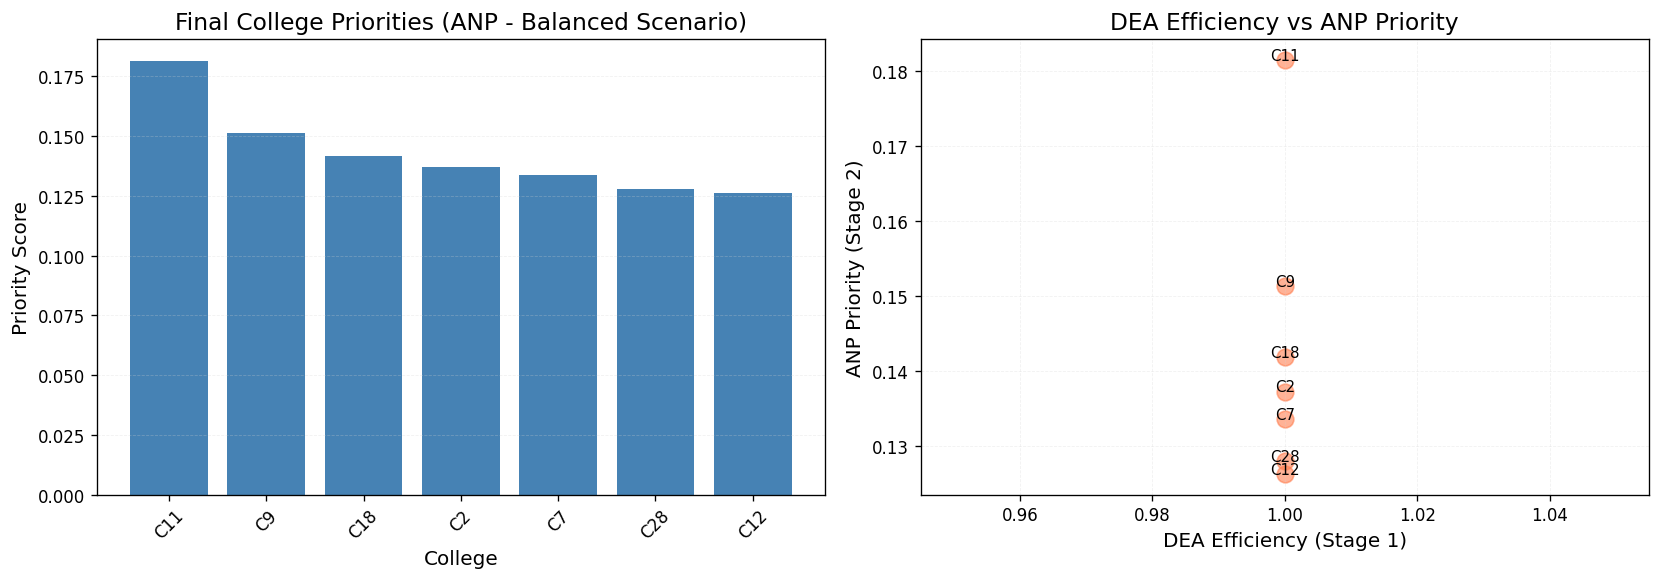


FINAL RECOMMENDATIONS (Balanced Scenario)
College  ANP_Priority
    C11      0.181504
     C9      0.151375
    C18      0.141869
     C2      0.137281
     C7      0.133631
    C28      0.128058
    C12      0.126282


In [23]:
# Visualize final ANP results (Balanced scenario)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bar chart of priorities
ax1.bar(anp_results["College"], anp_results["ANP_Priority"], color='steelblue')
ax1.set_title("Final College Priorities (ANP - Balanced Scenario)")
ax1.set_ylabel("Priority Score")
ax1.set_xlabel("College")
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Comparison with DEA scores
ax2.scatter(dea_df_sorted.set_index('College').loc[shortlisted_cols, 'DEA_Efficiency_Theta'],
           anp_results.set_index('College').loc[shortlisted_cols, 'ANP_Priority'],
           s=100, alpha=0.6, c='coral')
for i, college in enumerate(shortlisted_cols):
    ax2.annotate(college, 
                (dea_df_sorted.set_index('College').loc[college, 'DEA_Efficiency_Theta'],
                 anp_results.set_index('College').loc[college, 'ANP_Priority']),
                fontsize=9, ha='center')
ax2.set_xlabel("DEA Efficiency (Stage 1)")
ax2.set_ylabel("ANP Priority (Stage 2)")
ax2.set_title("DEA Efficiency vs ANP Priority")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("FINAL RECOMMENDATIONS (Balanced Scenario)")
print("="*80)
print(anp_results.to_string(index=False))


## IMPROVEMENT #5: Sensitivity Analysis

Test the robustness of rankings across different weight scenarios.
This helps identify which colleges are stable choices vs. scenario-dependent.

We'll compare 5 scenarios:
1. **Balanced** (Default weights)
2. **Academic Focus** (50% Academic, others reduced proportionally)
3. **Financial Focus** (40% Financial, others reduced proportionally)
4. **Reputation Focus** (60% Reputation, others reduced proportionally)
5. **Campus Life Focus** (40% Campus, others reduced proportionally)


In [24]:
def compute_anp_with_weights(cluster_weights, cluster_scores_df, local_weights, n_alt):
    """
    Compute ANP priorities with custom cluster weights.
    
    Args:
        cluster_weights: Dictionary with cluster names as keys and weights as values
        cluster_scores_df: DataFrame with cluster scores
        local_weights: Dictionary with local alternative priorities per cluster
        n_alt: Number of alternatives
    
    Returns:
        final_priorities: Array of final priorities for each alternative
    """
    clusters = list(cluster_weights.keys())
    n_clusters = len(clusters)
    cluster_priorities = np.array([cluster_weights[c] for c in clusters])
    
    # Build supermatrix
    N = n_alt * n_clusters
    supermatrix = np.zeros((N, N))
    
    def idx(cluster_index, alt_index):
        return cluster_index * n_alt + alt_index
    
    for i_cl in range(n_clusters):
        for j_cl in range(n_clusters):
            influence = cluster_priorities[j_cl]
            w_i = local_weights[clusters[i_cl]].values.reshape(-1, 1)
            block = w_i * influence
            r_start = i_cl * n_alt
            c_start = j_cl * n_alt
            supermatrix[r_start:r_start+n_alt, c_start:c_start+n_alt] = block
    
    # Column normalize
    col_sums = supermatrix.sum(axis=0)
    col_sums[col_sums == 0] = 1.0
    W = supermatrix / col_sums
    
    # Compute limit matrix
    limit = W.copy()
    for _ in range(150):
        limit = limit @ W
    
    # Aggregate final priorities
    final_priorities_raw = np.zeros(n_alt)
    for a in range(n_alt):
        rows = [idx(c, a) for c in range(n_clusters)]
        final_priorities_raw[a] = limit[rows, :].sum()
    
    final_priorities = final_priorities_raw / final_priorities_raw.sum()
    
    return final_priorities


# Define 5 scenarios with different cluster weights
scenarios = {
    "Balanced": {
        "Logistics": 0.079,
        "Academic": 0.244,
        "Financial": 0.137,
        "Campus": 0.137,
        "Reputation": 0.403
    },
    "Academic Focus": {
        "Logistics": 0.05,
        "Academic": 0.50,
        "Financial": 0.10,
        "Campus": 0.10,
        "Reputation": 0.25
    },
    "Financial Focus": {
        "Logistics": 0.10,
        "Academic": 0.20,
        "Financial": 0.40,
        "Campus": 0.10,
        "Reputation": 0.20
    },
    "Reputation Focus": {
        "Logistics": 0.05,
        "Academic": 0.15,
        "Financial": 0.10,
        "Campus": 0.10,
        "Reputation": 0.60
    },
    "Campus Life Focus": {
        "Logistics": 0.10,
        "Academic": 0.20,
        "Financial": 0.10,
        "Campus": 0.40,
        "Reputation": 0.20
    }
}

# Compute priorities for each scenario
scenario_results = {}
for scenario_name, weights in scenarios.items():
    priorities = compute_anp_with_weights(weights, cluster_scores, local_df, n_alt)
    scenario_results[scenario_name] = priorities

# Create results DataFrame
sensitivity_df = pd.DataFrame(scenario_results, index=anp_df["College"])
sensitivity_df = sensitivity_df.round(4)

print("\n" + "="*80)
print("SENSITIVITY ANALYSIS RESULTS")
print("="*80)
print("\nCollege Priorities Across Different Scenarios:")
print(sensitivity_df)

# Calculate rankings for each scenario
rankings_df = sensitivity_df.rank(ascending=False, method='min').astype(int)
print("\n" + "="*80)
print("Rankings Across Scenarios (1 = Best):")
print(rankings_df)



SENSITIVITY ANALYSIS RESULTS

College Priorities Across Different Scenarios:
         Balanced  Academic Focus  Financial Focus  Reputation Focus  \
College                                                                
C11        0.1815          0.1815           0.1815            0.1815   
C2         0.1373          0.1373           0.1373            0.1373   
C12        0.1263          0.1263           0.1263            0.1263   
C18        0.1419          0.1419           0.1419            0.1419   
C28        0.1281          0.1281           0.1281            0.1281   
C7         0.1336          0.1336           0.1336            0.1336   
C9         0.1514          0.1514           0.1514            0.1514   

         Campus Life Focus  
College                     
C11                 0.1815  
C2                  0.1373  
C12                 0.1263  
C18                 0.1419  
C28                 0.1281  
C7                  0.1336  
C9                  0.1514  

Rankings Ac

In [25]:
# Calculate rank stability metric
# Count how often each college appears in top 3 across scenarios
top_3_appearances = {}
for college in anp_df["College"]:
    count = sum(1 for scenario in scenarios.keys() if rankings_df.loc[college, scenario] <= 3)
    top_3_appearances[college] = count

stability_df = pd.DataFrame({
    "College": anp_df["College"],
    "Top_3_Appearances": [top_3_appearances[c] for c in anp_df["College"]],
    "Stability_Score": [top_3_appearances[c] / len(scenarios) for c in anp_df["College"]]
}).sort_values("Top_3_Appearances", ascending=False)

print("\n" + "="*80)
print("RANK STABILITY ANALYSIS")
print("="*80)
print("\nHow often each college appears in Top 3 across 5 scenarios:")
print(stability_df.to_string(index=False))

# Identify robust vs scenario-dependent choices
robust_colleges = stability_df[stability_df["Top_3_Appearances"] >= 3]["College"].tolist()
print(f"\nRobust Choices (appear in top 3 at least 3 times): {robust_colleges}")

scenario_dependent = stability_df[stability_df["Top_3_Appearances"] < 2]["College"].tolist()
if scenario_dependent:
    print(f"Scenario-Dependent (appear in top 3 less than 2 times): {scenario_dependent}")



RANK STABILITY ANALYSIS

How often each college appears in Top 3 across 5 scenarios:
College  Top_3_Appearances  Stability_Score
    C11                  5              1.0
    C18                  5              1.0
     C9                  5              1.0
     C2                  0              0.0
    C12                  0              0.0
    C28                  0              0.0
     C7                  0              0.0

Robust Choices (appear in top 3 at least 3 times): ['C11', 'C18', 'C9']
Scenario-Dependent (appear in top 3 less than 2 times): ['C2', 'C12', 'C28', 'C7']


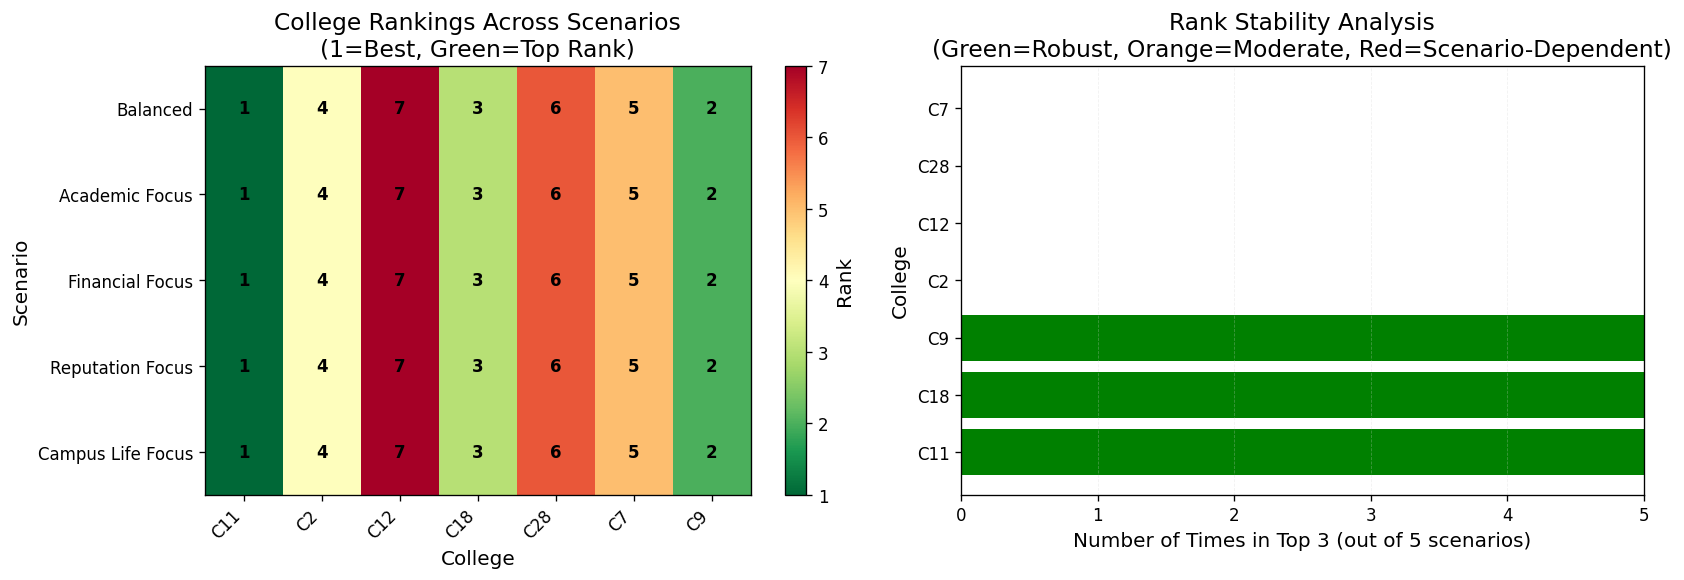

In [26]:
# Visualize scenario comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Rankings heatmap
ax = axes[0]
rankings_heatmap = rankings_df.T.values
im = ax.imshow(rankings_heatmap, cmap='RdYlGn_r', aspect='auto', vmin=1, vmax=7)
ax.set_xticks(range(len(anp_df["College"])))
ax.set_xticklabels(anp_df["College"], rotation=45, ha='right')
ax.set_yticks(range(len(scenarios)))
ax.set_yticklabels(scenarios.keys())
ax.set_title("College Rankings Across Scenarios\n(1=Best, Green=Top Rank)")
ax.set_xlabel("College")
ax.set_ylabel("Scenario")

# Add text annotations
for i in range(len(scenarios)):
    for j in range(len(anp_df["College"])):
        text = ax.text(j, i, int(rankings_heatmap[i, j]),
                      ha="center", va="center", color="black", fontsize=10, fontweight='bold')

plt.colorbar(im, ax=ax, label='Rank')

# Plot 2: Rank stability
ax = axes[1]
colors = ['green' if x >= 3 else 'orange' if x >= 2 else 'red' 
          for x in stability_df["Top_3_Appearances"]]
ax.barh(stability_df["College"], stability_df["Top_3_Appearances"], color=colors)
ax.set_xlabel("Number of Times in Top 3 (out of 5 scenarios)")
ax.set_ylabel("College")
ax.set_title("Rank Stability Analysis\n(Green=Robust, Orange=Moderate, Red=Scenario-Dependent)")
ax.set_xlim(0, 5)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()
